In [57]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sentinel-1 WOFS Product Creation

## Config
Import required DC utils

In [58]:
import datacube
# DC utilities
from datacube.storage import masking
from utils_dcal.data_cube_utilities.import_export import export_xarray_to_netcdf

Define aoi via wkt polygon (could be subbed or shapefile)

In [59]:
#aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
#aoi_wkt = "POLYGON((178.24905395508 -18.036804199219, 178.51547241212 -18.038177490235, 178.51547241212 -18.220825195313, 178.25454711915 -18.220825195313, 178.24905395508 -18.036804199219))"
aoi_wkt = "POLYGON((178.11035156251 -17.841796875, 178.83544921876 -17.830810546875, 178.83544921876 -18.297729492187, 178.10485839844 -18.30322265625, 178.11035156251 -17.841796875))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')

In [60]:
dc = datacube.Datacube(app="s1na")

In [61]:
area_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ]
          ]
        ]
      }
    }
  ]
}

In [62]:
lons, lats = zip(*area_json["features"][0]["geometry"]["coordinates"][0])
lat_extents = (min(lats), max(lats))
lon_extents = (min(lons), max(lons))
print("Lat:", lat_extents, "\n"
      "Lon:", lon_extents)

Lat: (-18.30322265625, -17.830810546875) 
Lon: (178.10485839844, 178.83544921876)


## Load Data
Generic query specs

In [63]:
time_step = '12M'
query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:32760",
                time = (datetime(2018,5,1), datetime(2019,5,1)),
                resolution = (90,90))

Dataset-specifics

In [64]:
scenes = dc.load(product="s1g_gamma0_scene",
                 group_by='solar_day',
               **query)

In [65]:
s1_coverage = masking.mask_invalid_data(scenes)

In [66]:
s1_coverage_clean = s1_coverage.where(s1_coverage!=0)


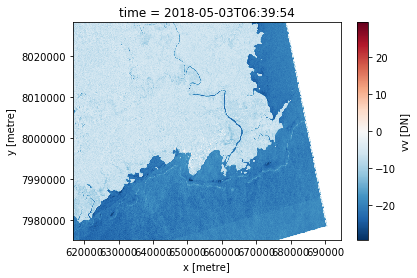

In [67]:
s1_coverage_clean.isel(time = 0).vv.plot();

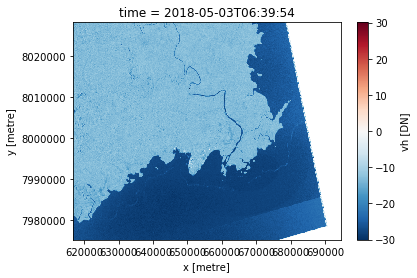

In [68]:
s1_coverage_clean.isel(time = 0).vh.plot();

In [69]:
# lee filter implemnation doesn't consider nan
from utils_sac.clean_mask import lee_filter
# save the nodata mask
nodata_mask = s1_coverage_clean.isnull().to_array().any(axis=0)
# replace nan with 0
s1_coverage_zerofilled = s1_coverage.where(~s1_coverage.isnull(), 0)

In [70]:
smoothed_vv=s1_coverage_zerofilled.vv.groupby('time').apply(lee_filter, size=7)
smoothed_vh=s1_coverage_zerofilled.vh.groupby('time').apply(lee_filter, size=7)

In [71]:
smoothed=smoothed_vv.to_dataset(name='vv')
smoothed['vh']=smoothed_vh

In [72]:
# put nodata back
smoothed=smoothed.where(~nodata_mask)

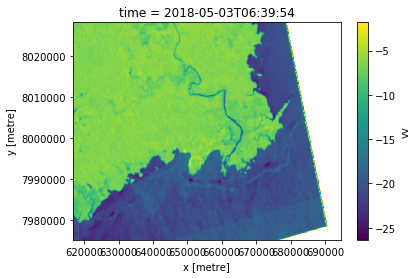

In [73]:
smoothed.isel(time=0).vv.plot()


Replace 0 with nan and negative with a small value

In [74]:
clean=smoothed.copy()
clean['vv'] =clean.vv.where(~clean.vv.isnull(), 1000)
clean['vh'] =clean.vh.where(~clean.vh.isnull(), 1000)
print("# of negative pixels in vv vh:", (clean.vv<0).sum().values, (clean.vh<0).sum().values)
#visual check
#(clean.vh<0).any(dim='time').plot()
clean['vv'] =clean.vv.where(clean.vv>0, 1e-3)
clean['vh'] =clean.vh.where(clean.vh>0, 1e-4)
clean=clean.where(clean<1000)

# of negative pixels in vv vh: 22606066 22606537


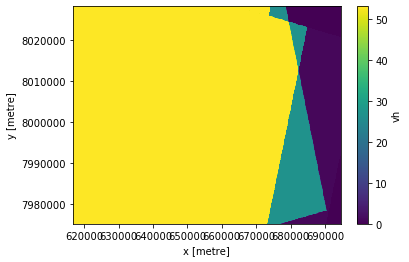

In [75]:
# number of valid observations
clean.vh.count(dim='time').plot()

Add vv+vh, vh/vv

In [76]:
clean['vv_plus_vh']=clean.vh+clean.vv
clean['vh_over_vv']=clean.vh/clean.vv
print(clean)

<xarray.Dataset>
Dimensions:     (time: 53, x: 865, y: 588)
Coordinates:
  * y           (y) float64 7.975e+06 7.975e+06 ... 8.028e+06 8.028e+06
  * x           (x) float64 6.167e+05 6.168e+05 ... 6.944e+05 6.945e+05
  * time        (time) datetime64[ns] 2018-05-03T06:39:54 ... 2019-03-28T17:40:15
Data variables:
    vv          (time, y, x) float32 0.001 0.001 0.001 0.001 ... nan nan nan nan
    vh          (time, y, x) float32 1e-04 1e-04 1e-04 1e-04 ... nan nan nan nan
    vv_plus_vh  (time, y, x) float32 0.0011 0.0011 0.0011 0.0011 ... nan nan nan
    vh_over_vv  (time, y, x) float32 0.099999994 0.099999994 ... nan nan


In [77]:
# Filter On
# s1_coverage['Observations'] = ((smoothed_vv <= vv_threshold) & (smoothed_vh <= vh_threshold))

# percentage of total of images in a time window that need to be water to include in the output.

# >>>>>>>>>>>>>>>>>>>>>> CHANGE HERE 
threshold = 70

# Don't change these detection parameters
min_vertices = 100
# water settings in sar
vv_threshold = 12
vh_threshold = -15.5

# Filter Off
s1_coverage['wofs'] = ((smoothed["vv"] <= vv_threshold) & (smoothed["vh"] <= vh_threshold))

In [78]:
#chunks = s1_coverage['wofs'].resample(time=time_step).sum('time')
#for t in range(0, chunks.time.size):
#    layer = chunks.isel(time=t)
#    layer_max = layer.max().values
#    layer_threshold = (layer_max / 100 ) * threshold
#    print(f"{t} t: {layer_threshold} m: {layer_max}")
#    print(layer.time.values)
    
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>CHANGE HERE   

# Threshold Images 
 #   layer.where(layer > layer_threshold).plot.imshow(figsize=(12*ar,10))
# Full Range Images    
 #   layer.where(layer_max > layer_threshold).plot.imshow(figsize=(12,10))
    
 #   plt.title(f"{layer.time.values}_-_{layer_max}_Observation(s)")
 #   plt.xlabel("Longitude (meters)")
 #   plt.ylabel("Latitude (meters)")
 #   contour = extract_contour(s1_coverage, layer, layer_threshold, min_vertices)
# Coastline Monitoring  
    #save_poly(f"Inland_water_monitoring/Coastline_{t}.geojson", s1_coverage.crs, contour)
# Inland Water Monitoring        
  #  plt.savefig(f"Inland_water_monitoring/Inland_{layer.time.values}.jpg")
  #  plt.show()

## Export to file within shared storage
Define output path

In [79]:
# Ensure the output directory exists before writing to it.
!mkdir -p /home/shared/geo_demos/wofs_testers
output_file_name  =  "/home/shared/geo_demos/wofs_testers/s1_wofs_product_VL.nc"

Correct attributes and add to wofs xarray (for some reason we have 'dc_partual_load' as true....)

In [80]:
s1_coverage.attrs

OrderedDict([('crs', CRS('EPSG:32760'))])

In [81]:
dataset_to_output =  s1_coverage.assign_attrs(s1_coverage.attrs)

In [82]:
dataset_to_output.attrs

OrderedDict([('crs', CRS('EPSG:32760'))])

In [83]:
#export_xarray_to_netcdf(dataset_to_output, output_file_name)
export_xarray_to_netcdf(dataset_to_output, output_file_name)

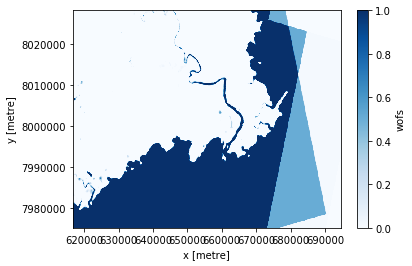

In [84]:
s1_coverage.wofs.mean(dim = 'time').plot(cmap = "Blues");